adapted from Gao et al. 2010 (http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5545418)

In [728]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import pickle
from astropy.table import Column
from astropy.table import Table
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist
from itertools import product
%matplotlib inline

# preparing input data

In [650]:
# loading training labels
f = open('/Users/eilers/Dropbox/cygnet/data/training_labels_apogee_tgas.pickle', 'r')
training_labels = pickle.load(f)
f.close()

# loading normalized spectra
f = open('/Users/eilers/Dropbox/cygnet/data/apogee_spectra_norm.pickle', 'r')    
spectra = pickle.load(f)
f.close()

wl = spectra[:, 0, 0]
fluxes = spectra[:, :, 1].T
ivars = (1./(spectra[:, :, 2]**2)).T 

In [651]:
# remove duplicates       
foo, idx = np.unique(training_labels['APOGEE_ID'], return_index = True)
training_labels = training_labels[idx]
fluxes = fluxes[idx, :]
ivars = ivars[idx, :]
        
# data masking       
masking = training_labels['K'] < 0.
training_labels = training_labels[~masking]
fluxes = fluxes[~masking]
ivars = ivars[~masking]

# scaling of data and training labels?!

In [652]:
# calculate K_MAG_ABS and Q

Q = 10**(0.2*training_labels['K']) * training_labels['parallax']/100.                    # assumes parallaxes is in mas
Q_err = training_labels['parallax_error'] * 10**(0.2*training_labels['K'])/100. 
Q = Column(Q, name = 'Q_MAG')
Q_err = Column(Q_err, name = 'Q_MAG_ERR')
training_labels.add_column(Q, index = 12)
training_labels.add_column(Q_err, index = 13)

In [653]:
# latex

latex = {}
latex["TEFF"] = r"$T_{\rm eff}$"
latex["LOGG"] = r"$\log g$"
latex["FE_H"] = r"$\rm [Fe/H]$"
latex["ALPHA_M"] = r"$[\alpha/\rm M]$"
latex["C_FE"] = r"$\rm [C/Fe]$"
latex["N_FE"] = r"$\rm [N/Fe]$"
latex["Q_MAG"] = r"$Q$"

In [654]:
def make_label_input(labels, training_labels):
    tr_label_input = np.array([training_labels[x] for x in labels]).T
    tr_ivar_input = 1./((np.array([training_labels[x+'_ERR'] for x in labels]).T)**2)
    for x in range(tr_label_input.shape[1]):
        bad = np.logical_or(tr_label_input[:, x] < -100., tr_label_input[:, x] > 9000.) # magic
        tr_label_input[bad, x] = np.median(tr_label_input[:, x])
        tr_ivar_input[bad, x] = 0.
    # remove one outlier in T_eff and [N/Fe]!
    bad = tr_label_input[:, 0] > 5200.
    tr_label_input[bad, 0] = np.median(tr_label_input[:, 0])
    tr_ivar_input[bad, 0] = 0.  
    #bad = tr_label_input[:, 5] < -0.6
    #tr_label_input[bad, 5] = np.median(tr_label_input[:, 5])
    #tr_ivar_input[bad, 5] = 0.     
    return tr_label_input, tr_ivar_input

In [1161]:
labels = np.array(['TEFF', 'FE_H']) #, 'LOGG']) #, 'ALPHA_M', 'Q_MAG', 'N_FE', 'C_FE'])
Nlabels = len(labels)
latex_labels = [latex[l] for l in labels]
tr_label_input, tr_ivar_input = make_label_input(labels, training_labels)
print(Nlabels, tr_label_input.shape, tr_ivar_input.shape, fluxes.shape, ivars.shape)

(2, (2180, 2), (2180, 2), (2180, 8575), (2180, 8575))


In [1162]:
# scale and pivot labels
def get_pivots_and_scales(label_vals):  
    qs = np.percentile(label_vals, (2.5, 50, 97.5), axis=0)
    pivots = qs[1]
    scales = (qs[2] - qs[0])/4.    
    return pivots, scales

pivots, scales = get_pivots_and_scales(tr_label_input)
tr_label_input_scaled = (tr_label_input - pivots) / scales
print('pivots: {}'.format(pivots))
print('scales: {}'.format(scales))

pivots: [  4.22088330e+03  -2.17777684e-01]
scales: [ 200.23879089    0.48587545]


In [1163]:
# take subset of data as input data
X = fluxes[:2, 500:510]
Y = tr_label_input_scaled[:2, :]
print X.shape, Y.shape 
N = X.shape[0]
D = X.shape[1]
L = Y.shape[1]
assert Y.shape[0] == N

(2, 10) (2, 2)


# Supervised GPLVM

X: input spectra -- N x D

Y: input labels -- N x L

Z: latent space -- N x Q with Q>=L

In [1271]:
def logLikelihood_Z(pars, X, Y, hyper_params):
    
    Z = np.reshape(pars, (Y.shape[0], Y.shape[1]))  
    theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2 = hyper_params    
    kernel1 = kernelRBF(Z, theta_rbf, theta_band, sigmax2)
    kernel2 = kernelRBF(Z, gamma_rbf, gamma_band, sigmay2)
    
    Lx = LxOrLy(kernel1, X)                      # eq. (18)
    Ly = LxOrLy(kernel2, Y)                      # eq. (19)    
    #print('L_Z: L_x={} '.format(Lx) + 'L_y={}'.format(Ly))
    L = Lx + Ly + 0.5 * np.linalg.norm(Z)        # eq. (20)     
    
    gradL = dLdZ(X, Y, Z, kernel1, kernel2, theta_band, gamma_band)    
    # reshape gradL back into 1D array
    gradL = np.reshape(gradL, (Y.shape[0] * Y.shape[1], ))
        
    return -2.*L, -2.*gradL
                    
def logLikelihood_hyper(pars, X, Y, Z):
    
    Z = np.reshape(Z, (Y.shape[0], Y.shape[1]))      
    theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2 = pars   
    kernel1 = kernelRBF(Z, theta_rbf, theta_band, sigmax2)
    kernel2 = kernelRBF(Z, gamma_rbf, gamma_band, sigmay2)
    
    Lx = LxOrLy(kernel1, X)                      # eq. (18)
    Ly = LxOrLy(kernel2, Y)                      # eq. (19)    
    #print('L_h: L_x={} '.format(Lx) + 'L_y={}'.format(Ly))
    L = Lx + Ly + 0.5 * np.linalg.norm(Z)        # eq. (20) 
    
    gradL = dLdhyper(X, Y, Z, kernel1, kernel2, pars)  
    return -2.*L, -2.*gradL


# eq. (21), (22)
def dLdZ(X, Y, Z, kernel1, kernel2, theta_band, gamma_band):   
    dlnpdZ = Z / np.linalg.norm(Z)
    gradL = np.dot(dLdK(kernel1, X), dKdZ(theta_band, kernel1, Z)) + np.dot(dLdK(kernel2, Y), dKdZ(gamma_band, kernel2, Z)) + dlnpdZ  
    return gradL

def A_matrix(Z):                                 # should be shape: (N x N) x (N x Q)...
    N, Q = Z.shape[0], Z.shape[1]
    A = np.zeros((N, N, N, Q))
    for entry in list(product(range(N), repeat=3)):
        i, j, l = entry
        if l == j:
            A[i, j, l, :] += Z[i, :] - Z[l, :]
            #print i, j, l, A[i, j, l, :]
        if l == i:
            A[i, j, l, :] += Z[j, :] - Z[l, :]
            #print i, j, l, A[i, j, l, :]
    return A


# eq. (25), (26)
def dKdZ(band, kernel, Z):
    A = A_matrix(Z)
    grad_dKdZ = band * np.tensordot(kernel, A)
    return grad_dKdZ                     


# eq. (23), (24)
def dLdK(K, data):         
    grad_dLdK = (np.dot(np.linalg.inv(K), np.dot(data, np.dot(data.T, np.linalg.inv(K)))) - data.shape[1] * np.linalg.inv(K))
    return grad_dLdK                     # shape: N x N 


# eq. (28)
def dLdhyper(X, Y, Z, kernel1, kernel2, hyper_params):    
    theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2 = hyper_params 
    
    dKdrbf, dKdband, dKdsigma2 = dKdhyper(Z, kernel1, theta_rbf, theta_band, sigmax2) 
    dLdtheta_rbf = np.tensordot(dLdK(kernel1, X), dKdrbf)
    dLdtheta_band = np.tensordot(dLdK(kernel1, X), dKdband)
    dLdtheta_sigma2 = np.tensordot(dLdK(kernel1, X), dKdsigma2)
    
    dKdrbf, dKdband, dKdsigma2 = dKdhyper(Z, kernel2, gamma_rbf, gamma_band, sigmay2)  
    dLdgamma_rbf = np.tensordot(dLdK(kernel2, Y), dKdrbf)
    dLdgamma_band = np.tensordot(dLdK(kernel2, Y), dKdband)
    dLdgamma_sigma2 = np.tensordot(dLdK(kernel2, Y), dKdsigma2)
    return np.array([dLdtheta_rbf, dLdtheta_band, dLdtheta_sigma2, dLdgamma_rbf, dLdgamma_band, dLdgamma_sigma2])


# eq. (29), (30)
def dKdhyper(Z, K, rbf, band, sigma2):
    dKdrbf = 1./rbf * K
    B = np.log(rbf_kernel(Z, gamma = 0.5))
    dKdband = np.dot(K, B)
    dKdsigma2 = np.eye(K.shape[0])    
    return dKdrbf, dKdband, dKdsigma2


# eq. (18), (19)
def LxOrLy(K, data):   
    L_term1 = -0.5 * data.shape[0] * data.shape[1] * np.log(2.*np.pi)
    L_term2 = -0.5 * data.shape[1] * np.log(np.linalg.det(K))
    L_term3 = -0.5 * np.matrix.trace(np.dot(np.linalg.inv(K), np.dot(data, data.T)))
    return L_term1 + L_term2 + L_term3


# radius basis function
def kernelRBF(Z, rbf, band, sigma2):    
    kernel = rbf * rbf_kernel(Z, gamma = 0.5 * band) + sigma2 * np.eye(Z.shape[0])
    return kernel


def PCAInitial(X, Q):
    pca = PCA(Q)
    Z_initial = pca.fit_transform(X)
    return Z_initial

In [1279]:
def test_likelihood_h(pars, X, Y, Z):
    
    q, dldq = logLikelihood_hyper(pars, X, Y, Z)
    
    for k in range(len(pars)):
        pars1 = 1. * pars
        tiny = 1e-7 * pars[k]
        pars1[k] += tiny
        q1, foo = logLikelihood_hyper(pars1, X, Y, Z)
        dldqk = (q1 - q)/tiny
        print(k, q, q1, dldqk, dldq[k], (dldq[k]-dldqk)/(dldq[k]+dldqk))
    return

def test_likelihood_Z(pars, X, Y, hyper_params):
    
    q, dldq = logLikelihood_Z(pars, X, Y, hyper_params)
    
    for k in range(len(pars)):
        pars1 = 1. * pars
        tiny = 1e-7 * pars[k]
        pars1[k] += tiny
        q1, foo = logLikelihood_Z(pars1, X, Y, hyper_params)
        dldqk = (q1 - q)/tiny
        print(k, q, q1, dldqk, dldq[k], (dldq[k]-dldqk)/(dldq[k]+dldqk))
    return

In [1281]:
# initialization 
theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2 = 1, 1, 1, 1, 1, 1
hyper_params = np.array([theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2])

Q = Y.shape[1]
Z_initial = Y[:] #PCAInitial(X, Q)
Z = Z_initial[:]
Z = np.reshape(Z, (N*Q, ))
print Z.shape, Z

(4,) [ 2.07809502 -3.01397246 -1.79058551 -0.59766333]


(2, 2)


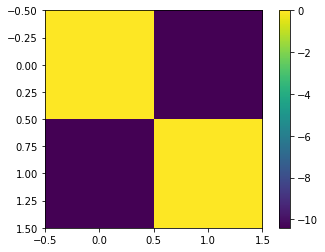

In [1182]:
kernel1 = kernelRBF(Z_initial, theta_rbf, theta_band, sigmax2)
kernel2 = kernelRBF(Z_initial, theta_rbf, theta_band, sigmax2)
print kernel1.shape
#B = -0.5 * cdist(Z_initial, Z_initial).T * cdist(Z_initial, Z_initial) 
B = np.log(rbf_kernel(Z_initial, gamma = 0.5))
plt.imshow(B, interpolation='None')
plt.colorbar()

In [1282]:
grad_dLdK = dLdK(kernel1, X)
dKdrbf, dKdband, dKdsigma2 = dKdhyper(Z_initial, kernel1, theta_rbf, theta_band, sigmax2)
L, gradL = logLikelihood_hyper(hyper_params, X, Y, Z)
print L, gradL
hyper_new = hyper_params[:] 
hyper_new = (1. + 1e-7) * hyper_params
# print hyper_new
L, gradL = logLikelihood_hyper(hyper_new, X, Y, Z)
print L, gradL

74.9719131511 [  20.27336434  205.19882115   10.13683186   -8.96596509  -39.94178885
   -4.48301168]
74.9719137166 [  20.27336429  205.19880063   10.13683183   -8.96596249  -39.94178485
   -4.48301038]


In [1280]:
# testing likelihood functions
test_likelihood_h(hyper_params, X, Y, Z)
test_likelihood_Z(Z, X, Y, hyper_params)

(0, 74.971913151062964, 74.971913657889601, 5.0682663754741952, 20.27336434466072, 0.60000471702499714)
(1, 74.971913151062964, 74.971913151218686, 0.0015572254596918356, 205.19882114777613, 0.99998482239192699)
(2, 74.971913151062964, 74.971913657904565, 5.0684160157743463, 10.136831857479152, 0.33333332570133933)
(3, 74.971913151062964, 74.971912926915309, -2.2414765510347934, -8.9659650874816101, 0.60000210158015843)
(4, 74.971913151062964, 74.971913151032652, -0.00030311753107525874, -39.941788847559963, 0.99998482215046025)
(5, 74.971913151062964, 74.971912926912395, -2.2415056832869595, -4.4830116804151583, 0.33333336444746114)
(0, 74.971913151062964, 74.971913046316189, -0.50405190209732453, -1.0121072585480746, 0.33509368253559929)
(1, 74.971913151062964, 74.971912930609406, 0.73143852747639893, 1.4653775613484692, 0.334092160743721)
(2, 74.971913151062964, 74.971913073306681, 0.43425059963847473, 0.87594278774934253, 0.33711984227876957)
(3, 74.971913151062964, 74.971913142373

In [1284]:
# iterative algorithm (Table 1)

max_iter = 1
for t in range(max_iter):
    
    # optimize hyperparameters
    print("optimizing hyper parameters")
    res = op.minimize(logLikelihood_hyper, x0 = hyper_params, args = (X, Y, Z), method = 'L-BFGS-B', jac = True, 
                      options={'gtol':1e-12, 'ftol':1e-12})
    
    # update hyperparameters
    hyper_params = res.x
             
    # optimize Z
    print("optimizing latent parameters")
    res = op.minimize(logLikelihood_Z, x0 = Z, args = (X, Y, hyper_params), method = 'L-BFGS-B', jac = True, 
                      options={'gtol':1e-12, 'ftol':1e-12})
             
    # update Z
    Z = res.x
    
    # check convergence
 
Z_final = np.reshape(Z, (N, Q))

optimizing hyper parameters
optimizing latent parameters


/Users/eilers/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:96: RuntimeWarning: invalid value encountered in log


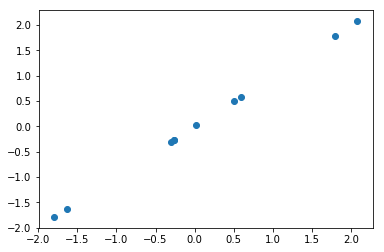

In [665]:
plt.scatter(Z_initial[:, 0], Z_final[:, 0])

# testing stuff...

In [1046]:
N, Q, D = 2, 2, 10
X = np.ones((N, D))
Y = np.ones((N, Q))
Y[0, 0] = 2. 
Y[0, 1] = -1.
Y[1, 0] = -2.
print Y
Z_initial = Y[:]
Z = Z_initial[:]
#Z = np.reshape(Z, (N*Q, ))
print Z.shape

[[ 2. -1.]
 [-2.  1.]]
(2, 2)


In [1047]:
theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2 = 1, 1, 1, 1, 1, 1
hyper_params = np.array([theta_rbf, theta_band, sigmax2, gamma_rbf, gamma_band, sigmay2])

In [1048]:
# test kernel!

kernel1 = kernelRBF(Z_initial, theta_rbf, theta_band, sigmax2)
print kernel1

# manual test
K = np.zeros((N, N))
for i in range(2):
    for j in range(2):
        K[i, j] = theta_rbf * np.exp(-0.5 * theta_band * ( (Z[i, 0] - Z[j, 0])**2 +  (Z[i, 1] - Z[j, 1])**2)) 
print K + sigmax2*np.eye(N)

[[  2.00000000e+00   4.53999298e-05]
 [  4.53999298e-05   2.00000000e+00]]
[[  2.00000000e+00   4.53999298e-05]
 [  4.53999298e-05   2.00000000e+00]]


In [1049]:
# test Lx and Ly

Lx = LxOrLy(kernel1, Y)

det = kernel1[0, 0] * kernel1[1, 1] - kernel1[0, 1] * kernel1[1, 0]
print det, np.linalg.det(kernel1)

inv_mat = np.zeros((N, N))
inv_mat[0, 0] = 1./det * kernel1[1, 1]
inv_mat[1, 0] = -1./det * kernel1[0, 1]
inv_mat[0, 1] = -1./det * kernel1[1, 0]
inv_mat[1, 1] = -1./det * kernel1[0, 0]
#print inv_mat, np.linalg.inv(kernel1)

Lx_man = - 0.5 * Q * N * np.log(2*np.pi)
Lx_man += - 0.5 * Q * np.log(np.linalg.det(kernel1))
brackets = np.dot( np.linalg.inv(kernel1), np.dot(Y, Y.T))
Lx_man += - 0.5 * np.matrix.trace(brackets)
print Lx, Lx_man

3.99999999794 3.99999999794
-7.56210524462 -7.56210524462


In [1050]:
# test dKdhyper

dKdrbf, dKdband, dKdsigma2 = dKdhyper(Z, kernel1, theta_rbf, theta_band, sigmax2)

drbf = 1/theta_rbf * kernel1
print dKdrbf - drbf
print dKdsigma2 - np.eye(2)
B = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        B[i, j] = -0.5 * ( (Z[i, 0] - Z[j, 0])**2 + (Z[i, 1] - Z[j, 1])**2)
print dKdband - np.dot(kernel1, B)

[[ 0.  0.]
 [ 0.  0.]]
[[ 0.  0.]
 [ 0.  0.]]
[[ 0.  0.]
 [ 0.  0.]]


In [1051]:
# test dLdK
K = kernel1
grad_dLdK = dLdK(K, Y)
#print grad_dLdK

term1 = np.zeros((2, 2))
term1[0, 0] = 5 * (K[1, 1] + K[1, 0]) * (K[1, 1] + K[0, 1])
term1[0, 1] = 5 * (K[0, 1] + K[0, 0]) * (-K[1, 1] - K[0, 1])
term1[1, 0] = 5 * (K[1, 1] + K[1, 0]) * (-K[1, 0] - K[0, 0]) 
term1[1, 1] = 5 * (K[0, 0] + K[0, 1]) * (K[0, 0] + K[1, 0]) 

term2 = Q * np.linalg.inv(K)
#print term1/(det**2) + term2

#xx = np.dot(np.linalg.inv(K), np.dot(Y, np.dot(Y.T, np.linalg.inv(K))))
#print xx - term2
print term1/(det**2) - term2
print grad_dLdK

[[ 0.25005675 -1.25003405]
 [-1.25003405  0.25005675]]
[[ 0.25005675 -1.25003405]
 [-1.25003405  0.25005675]]


In [1052]:
# test dLdhyper

xx = np.tensordot(grad_dLdK, dKdrbf)
print xx
bla = 1./ theta_rbf * (grad_dLdK[0, 0]*dKdrbf[0, 0] + grad_dLdK[1, 0]*dKdrbf[1, 0] + grad_dLdK[0, 1]*dKdrbf[0, 1] + grad_dLdK[1, 1]*dKdrbf[1, 1])
print bla

xx = np.tensordot(grad_dLdK, dKdsigma2)
print xx
bla = grad_dLdK[0, 0]*dKdsigma2[0, 0] + grad_dLdK[1, 1]*dKdsigma2[1, 1]
print bla

xx = np.tensordot(grad_dLdK, dKdband)
print xx
KB = np.zeros((2, 2))
KB[0,0] = K[0,0]*B[0,0] + K[0,1]*B[1,0]
KB[0,1] = K[0,0]*B[0,1] + K[0,1]*B[1,1]
KB[1,0] = K[1,0]*B[0,0] + K[1,1]*B[1,0]
KB[1,1] = K[1,0]*B[0,1] + K[1,1]*B[1,1]
bla = (grad_dLdK[0, 0]*KB[0, 0] + grad_dLdK[1, 0]*KB[1, 0] + grad_dLdK[0, 1]*KB[0, 1] + grad_dLdK[1, 1]*KB[1, 1])
print bla
print KB - np.dot(kernel1, B)

1.0001135024
1.0001135024
0.500113502659
0.500113502659
50.001135024
50.001135024
[[ 0.  0.]
 [ 0.  0.]]


In [1053]:
print np.asarray(KB)

[[ -4.53999298e-04  -2.00000000e+01]
 [ -2.00000000e+01  -4.53999298e-04]]
